In [1]:
import copy

import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
        
BH_tif_400_400 = pd.read_csv('useful_data/BH_tif_400_400.csv', sep = ',', header = None)
BV_tif_400_400 = pd.read_csv('useful_data/BV_tif_400_400.csv', sep = ',', header = None)
CNM_tif_400_400 = pd.read_csv('useful_data/CNM_tif_400_400.csv', sep = ',', header = None)
LAI_tif_400_400 = pd.read_csv('useful_data/LAI_tif_400_400.csv', sep = ',', header = None)
DSM_tif_400_400 = pd.read_csv('useful_data/DSM_tif_400_400.csv', sep = ',', header = None)

Air_Temperature_C_400_400 = pd.read_csv('useful_data/Air_Temperature_C_400_400.csv', sep = ',', header = None)
Dew_Point_C_400_400 = pd.read_csv('useful_data/Dew_Point_C_400_400.csv', sep = ',', header = None)
Relative_Humidity_400_400 = pd.read_csv('useful_data/Relative_Humidity_400_400.csv', sep = ',', header = None)
Wind_Speed_400_400 = pd.read_csv('useful_data/Wind_Speed_kn_400_400.csv', sep = ',', header = None)

In [3]:
BH_tif_400_400.shape

(400, 400)

In [4]:
BV_tif_400_400.shape

(400, 400)

In [5]:
CNM_tif_400_400.shape

(400, 400)

In [6]:
LAI_tif_400_400.shape

(400, 400)

In [7]:
DSM_tif_400_400.shape

(400, 400)

In [8]:
Air_Temperature_C_400_400.shape

(400, 400)

In [9]:
Dew_Point_C_400_400.shape

(400, 400)

In [10]:
Relative_Humidity_400_400.shape

(400, 400)

In [11]:
Wind_Speed_400_400.shape

(400, 400)

# 数据预处理

In [12]:
import numpy as np
from scipy import stats

def analyze_layers(inpute, name=None):
    print(f"分析 {name if name else '输入'} 层：")
    
    # 总体最值
    min_value = np.min(inpute)
    max_value = np.max(inpute)
    
    layer = inpute.values.flatten()
    unique, counts = np.unique(layer, return_counts=True)

    # 统计只出现1次的数值
    once_values = unique[counts == 1]
    num_once = len(once_values)

    # 计算均值、方差和中位数，最值
    mean_once = np.mean(once_values) if num_once > 0 else None
    var_once = np.var(once_values) if num_once > 0 else None
    median_once = np.median(once_values) if num_once > 0 else None
    min_once = np.min(once_values) if num_once > 0 else None
    max_once = np.max(once_values) if num_once > 0 else None
    
    # 统计只出现2次的数值
    twice_values = unique[counts == 2]
    num_twice = len(twice_values)
    
    # 计算均值、方差和中位数
    mean_twice = np.mean(twice_values) if num_twice > 0 else None
    var_twice = np.var(twice_values) if num_twice > 0 else None
    median_twice = np.median(twice_values) if num_twice > 0 else None
    min_twice = np.min(twice_values) if num_twice > 0 else None
    max_twice = np.max(twice_values) if num_twice > 0 else None
    
    # 统计只出现3次的数值
    thrice_values = unique[counts == 3]
    num_thrice = len(thrice_values)
    
    # 计算均值、方差和中位数
    mean_thrice = np.mean(thrice_values) if num_thrice > 0 else None
    var_thrice = np.var(thrice_values) if num_thrice > 0 else None
    median_thrice = np.median(thrice_values) if num_thrice > 0 else None
    min_thrice = np.min(thrice_values) if num_thrice > 0 else None
    max_thrice = np.max(thrice_values) if num_thrice > 0 else None

    # 统计不止出现3次的数值及其对应出现次数
    more_than_once = dict(zip(unique[counts > 3], counts[counts > 3]))

    # 打印输出结果
    print(f"总体最小值: {min_value}, 总体最大值: {max_value}")
    print(f"只出现1次的数值共有 {num_once} 个，它们出现了 {np.sum(counts[counts == 1])} 次。它们的均值、方差、中位数、最小值、最大值分别是 {mean_once}, {var_once}, {median_once}, {min_once}, {max_once}")
    print(f"只出现2次的数值共有 {num_twice} 个，它们出现了 {np.sum(counts[counts == 2])} 次。它们的均值、方差、中位数、最小值、最大值分别是 {mean_twice}, {var_twice}, {median_twice}, {min_twice}, {max_twice}")
    print(f"只出现3次的数值共有 {num_thrice} 个，它们出现了 {np.sum(counts[counts == 3])} 次。它们的均值、方差、中位数、最小值、最大值分别是 {mean_thrice}, {var_thrice}, {median_thrice}, {min_thrice}, {max_thrice}")
    if more_than_once:
        print("不止出现3次的数值及其对应出现次数进行逆序排列如下：")
        for value, count in sorted(more_than_once.items(), key=lambda x: x[1], reverse=True):
            print(f"{value:>10}  : {value.dtype} : {count}")
    else:
        print("没有不止出现1次的数值。")
    print()


In [13]:
analyze_layers(BH_tif_400_400, '建筑物高度')

分析 建筑物高度 层：
总体最小值: 1.0, 总体最大值: 65535.0
只出现1次的数值共有 1 个，它们出现了 1 次。它们的均值、方差、中位数、最小值、最大值分别是 339.0, 0.0, 339.0, 339.0, 339.0
只出现2次的数值共有 7 个，它们出现了 14 次。它们的均值、方差、中位数、最小值、最大值分别是 205.71428571428572, 8604.204081632653, 182.0, 102.0, 334.0
只出现3次的数值共有 4 个，它们出现了 12 次。它们的均值、方差、中位数、最小值、最大值分别是 186.0, 5781.5, 203.0, 78.0, 260.0
不止出现3次的数值及其对应出现次数进行逆序排列如下：
   65535.0  : float64 : 110004
     109.0  : float64 : 1798
     249.0  : float64 : 1338
     294.0  : float64 : 1312
       3.0  : float64 : 1039
     205.0  : float64 : 822
     342.0  : float64 : 698
      96.0  : float64 : 582
     340.0  : float64 : 552
     154.0  : float64 : 534
     315.0  : float64 : 528
     232.0  : float64 : 497
     299.0  : float64 : 482
     233.0  : float64 : 473
     268.0  : float64 : 456
     170.0  : float64 : 437
     104.0  : float64 : 433
     195.0  : float64 : 428
     215.0  : float64 : 394
     280.0  : float64 : 380
      75.0  : float64 : 376
     175.0  : float64 : 374
     269.0  : float64 : 374
     243.

In [14]:
BH_tif_400_400[BH_tif_400_400 == 65535] = 0

In [15]:
analyze_layers(BH_tif_400_400, '建筑物高度')

分析 建筑物高度 层：
总体最小值: 0.0, 总体最大值: 343.0
只出现1次的数值共有 1 个，它们出现了 1 次。它们的均值、方差、中位数、最小值、最大值分别是 339.0, 0.0, 339.0, 339.0, 339.0
只出现2次的数值共有 7 个，它们出现了 14 次。它们的均值、方差、中位数、最小值、最大值分别是 205.71428571428572, 8604.204081632653, 182.0, 102.0, 334.0
只出现3次的数值共有 4 个，它们出现了 12 次。它们的均值、方差、中位数、最小值、最大值分别是 186.0, 5781.5, 203.0, 78.0, 260.0
不止出现3次的数值及其对应出现次数进行逆序排列如下：
       0.0  : float64 : 110004
     109.0  : float64 : 1798
     249.0  : float64 : 1338
     294.0  : float64 : 1312
       3.0  : float64 : 1039
     205.0  : float64 : 822
     342.0  : float64 : 698
      96.0  : float64 : 582
     340.0  : float64 : 552
     154.0  : float64 : 534
     315.0  : float64 : 528
     232.0  : float64 : 497
     299.0  : float64 : 482
     233.0  : float64 : 473
     268.0  : float64 : 456
     170.0  : float64 : 437
     104.0  : float64 : 433
     195.0  : float64 : 428
     215.0  : float64 : 394
     280.0  : float64 : 380
      75.0  : float64 : 376
     175.0  : float64 : 374
     269.0  : float64 : 374
     243.0 

In [16]:
BH_tif_400_400.shape

(400, 400)

In [17]:
# 导出处理过后的数据
# output data after processing
BH_tif_400_400.to_csv('useful_data_after_processing/BH_tif_400_400_after_processing.csv', index=False, header=False)

In [18]:
analyze_layers(BV_tif_400_400, '建筑物体积')

分析 建筑物体积 层：
总体最小值: 0.0, 总体最大值: 1.79e+308
只出现1次的数值共有 1730 个，它们出现了 1730 次。它们的均值、方差、中位数、最小值、最大值分别是 16391.687108471044, 3506419458.347162, 4567.061551701699, 36.85867016874948, 1470306.4419853743
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
不止出现3次的数值及其对应出现次数进行逆序排列如下：
 1.79e+308  : float64 : 158260
       0.0  : float64 : 10



In [19]:
BV_tif_400_400_1 = BV_tif_400_400.copy()
BV_tif_400_400_1[BV_tif_400_400_1 > 9999999999] = 0


In [20]:
analyze_layers(BV_tif_400_400_1)

分析 输入 层：
总体最小值: 0.0, 总体最大值: 1470306.4419853743
只出现1次的数值共有 1730 个，它们出现了 1730 次。它们的均值、方差、中位数、最小值、最大值分别是 16391.687108471044, 3506419458.347162, 4567.061551701699, 36.85867016874948, 1470306.4419853743
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
不止出现3次的数值及其对应出现次数进行逆序排列如下：
       0.0  : float64 : 158270



In [21]:
# 打印BV_tif_400_400_1展平后数据逆序排列的前1000个

# 将 DataFrame 转换为 NumPy 数组并展平
flattened_data = BV_tif_400_400_1.values.flatten()

# 逆序排列
sorted_data = np.sort(flattened_data)[::-1]

# 获取前 1000 个元素
top_1000 = sorted_data[:1000]

# 打印这些元素
print(top_1000)

[1470306.44198537  928527.48432341  822498.02741678  788971.98125433
  745680.72287069  442546.75103305  305714.4602653   275586.26209238
  246765.75893422  238312.04999352  207110.45375614  189720.60802727
  188245.74152629  169231.57752936  167713.922905    154118.83669006
  153033.25411088  145120.15221684  143134.2704019   131573.44773744
  131350.58058033  131004.34971821  130321.64945956  121031.23358514
  118633.94475522  118139.53818828  115220.96459262  114814.4535276
  113358.15800788  111552.35809406  111328.56802306  108617.75803779
  105559.26627261  104191.32767899  102918.69186847  100889.96322373
  100840.34991788   99628.26747176   98337.34041797   98281.53957242
   97972.05909716   97672.70458754   97258.24025266   96354.9162421
   95948.17356644   95040.65623086   94679.11975892   91611.46641331
   89895.99780249   86741.85303346   86740.76785517   86333.16743003
   85814.36224663   84942.21896262   84846.03335051   84828.35964804
   83018.91124786   81791.39810884  

In [22]:
np.array(top_1000)

array([1470306.44198537,  928527.48432341,  822498.02741678,
        788971.98125433,  745680.72287069,  442546.75103305,
        305714.4602653 ,  275586.26209238,  246765.75893422,
        238312.04999352,  207110.45375614,  189720.60802727,
        188245.74152629,  169231.57752936,  167713.922905  ,
        154118.83669006,  153033.25411088,  145120.15221684,
        143134.2704019 ,  131573.44773744,  131350.58058033,
        131004.34971821,  130321.64945956,  121031.23358514,
        118633.94475522,  118139.53818828,  115220.96459262,
        114814.4535276 ,  113358.15800788,  111552.35809406,
        111328.56802306,  108617.75803779,  105559.26627261,
        104191.32767899,  102918.69186847,  100889.96322373,
        100840.34991788,   99628.26747176,   98337.34041797,
         98281.53957242,   97972.05909716,   97672.70458754,
         97258.24025266,   96354.9162421 ,   95948.17356644,
         95040.65623086,   94679.11975892,   91611.46641331,
         89895.99780249,

In [23]:
top_1000

array([1470306.44198537,  928527.48432341,  822498.02741678,
        788971.98125433,  745680.72287069,  442546.75103305,
        305714.4602653 ,  275586.26209238,  246765.75893422,
        238312.04999352,  207110.45375614,  189720.60802727,
        188245.74152629,  169231.57752936,  167713.922905  ,
        154118.83669006,  153033.25411088,  145120.15221684,
        143134.2704019 ,  131573.44773744,  131350.58058033,
        131004.34971821,  130321.64945956,  121031.23358514,
        118633.94475522,  118139.53818828,  115220.96459262,
        114814.4535276 ,  113358.15800788,  111552.35809406,
        111328.56802306,  108617.75803779,  105559.26627261,
        104191.32767899,  102918.69186847,  100889.96322373,
        100840.34991788,   99628.26747176,   98337.34041797,
         98281.53957242,   97972.05909716,   97672.70458754,
         97258.24025266,   96354.9162421 ,   95948.17356644,
         95040.65623086,   94679.11975892,   91611.46641331,
         89895.99780249,

In [24]:
# 绘制这1000个元素的图表
pd.DataFrame(top_1000)

,0
0,1.470306e+06
1,9.285275e+05
2,8.224980e+05
3,7.889720e+05
4,7.456807e+05
...,...
995,3.311985e+03
996,3.306427e+03
997,3.284247e+03
998,3.273530e+03


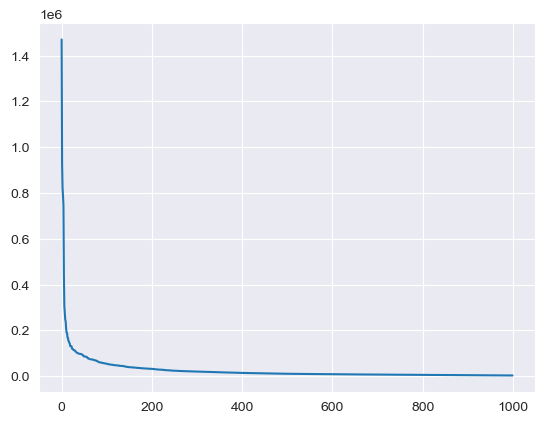

In [25]:
# 绘制top_1000
plt.plot(top_1000)
plt.savefig('top_1000.png')
plt.show()

In [26]:
# 导出处理过后的数据
# output data after processing
BV_tif_400_400_1.to_csv('useful_data_after_processing/BV_tif_400_400_after_processing.csv', index=False, header=False)

In [27]:
BV_tif_400_400_1.shape

(400, 400)

In [32]:
analyze_layers(BV_tif_400_400_1, '建筑物体积')

分析 建筑物体积 层：
只出现1次的数值共有 1730 个，它们出现了 1730 次。它们的均值、方差、中位数、最小值、最大值分别是 16391.687108471044, 3506419458.347162, 4567.061551701699, 36.85867016874948, 1470306.4419853743
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
不止出现3次的数值及其对应出现次数进行逆序排列如下：
       0.0  : float64 : 158270



In [33]:
analyze_layers(CNM_tif_400_400, '树冠高度')

分析 树冠高度 层：
只出现1次的数值共有 157546 个，它们出现了 157546 次。它们的均值、方差、中位数、最小值、最大值分别是 11.266621607891976, 135.02946473553902, 8.14175796508789, -5.016123294830321, 120.16422271728516
只出现2次的数值共有 1173 个，它们出现了 2346 次。它们的均值、方差、中位数、最小值、最大值分别是 3.6455419194667846, 51.061631160137075, 0.1460866928100586, 0.027047157287597656, 43.09093475341797
只出现3次的数值共有 32 个，它们出现了 96 次。它们的均值、方差、中位数、最小值、最大值分别是 0.7449982464313507, 12.32298418134708, 0.10537242889404297, 0.06846809387207031, 20.288631439208984
不止出现3次的数值及其对应出现次数进行逆序排列如下：
3.399999952144364e+38  : float64 : 12



In [34]:
CNM_tif_400_400_1 = CNM_tif_400_400.copy()
CNM_tif_400_400_1[CNM_tif_400_400_1 > 9999999999] = 0

In [35]:
analyze_layers(CNM_tif_400_400_1, '树冠高度')

分析 树冠高度 层：
只出现1次的数值共有 157546 个，它们出现了 157546 次。它们的均值、方差、中位数、最小值、最大值分别是 11.266621607891976, 135.02946473553902, 8.14175796508789, -5.016123294830321, 120.16422271728516
只出现2次的数值共有 1173 个，它们出现了 2346 次。它们的均值、方差、中位数、最小值、最大值分别是 3.6455419194667846, 51.061631160137075, 0.1460866928100586, 0.027047157287597656, 43.09093475341797
只出现3次的数值共有 32 个，它们出现了 96 次。它们的均值、方差、中位数、最小值、最大值分别是 0.7449982464313507, 12.32298418134708, 0.10537242889404297, 0.06846809387207031, 20.288631439208984
不止出现3次的数值及其对应出现次数进行逆序排列如下：
       0.0  : float64 : 12



In [36]:
# 导出处理过后的数据
# output data after processing

CNM_tif_400_400_1.to_csv('useful_data_after_processing/CNM_tif_400_400_after_processing.csv', index=False, header=False)

In [38]:
analyze_layers(CNM_tif_400_400_1, '树冠高度')

分析 树冠高度 层：
只出现1次的数值共有 157546 个，它们出现了 157546 次。它们的均值、方差、中位数、最小值、最大值分别是 11.266621607891976, 135.02946473553902, 8.14175796508789, -5.016123294830321, 120.16422271728516
只出现2次的数值共有 1173 个，它们出现了 2346 次。它们的均值、方差、中位数、最小值、最大值分别是 3.6455419194667846, 51.061631160137075, 0.1460866928100586, 0.027047157287597656, 43.09093475341797
只出现3次的数值共有 32 个，它们出现了 96 次。它们的均值、方差、中位数、最小值、最大值分别是 0.7449982464313507, 12.32298418134708, 0.10537242889404297, 0.06846809387207031, 20.288631439208984
不止出现3次的数值及其对应出现次数进行逆序排列如下：
       0.0  : float64 : 12



In [52]:
analyze_layers(LAI_tif_400_400, '叶面积指数')

分析 叶面积指数 层：
总体最小值: -1.8564494848251345, 总体最大值: 3.399999952144364e+38
只出现1次的数值共有 157462 个，它们出现了 157462 次。它们的均值、方差、中位数、最小值、最大值分别是 4.655510395760289, 21.607825432794446, 3.4041892290115356, -1.8564494848251345, 48.21569061279297
只出现2次的数值共有 1215 个，它们出现了 2430 次。它们的均值、方差、中位数、最小值、最大值分别是 1.7873545364465242, 9.17142720646783, 0.21081429719924927, 0.160818874835968, 17.38637351989746
只出现3次的数值共有 32 个，它们出现了 96 次。它们的均值、方差、中位数、最小值、最大值分别是 0.44799929903820157, 1.9716773726410368, 0.19214897602796555, 0.17738723754882812, 8.26545238494873
不止出现3次的数值及其对应出现次数进行逆序排列如下：
3.399999952144364e+38  : float64 : 12



In [40]:
LAI_tif_400_400_1 = LAI_tif_400_400.copy()
LAI_tif_400_400_1[LAI_tif_400_400_1 > 9999999999] = 0

In [53]:
analyze_layers(LAI_tif_400_400_1, '叶面积指数')

分析 叶面积指数 层：
总体最小值: -1.8564494848251345, 总体最大值: 48.21569061279297
只出现1次的数值共有 157462 个，它们出现了 157462 次。它们的均值、方差、中位数、最小值、最大值分别是 4.655510395760289, 21.607825432794446, 3.4041892290115356, -1.8564494848251345, 48.21569061279297
只出现2次的数值共有 1215 个，它们出现了 2430 次。它们的均值、方差、中位数、最小值、最大值分别是 1.7873545364465242, 9.17142720646783, 0.21081429719924927, 0.160818874835968, 17.38637351989746
只出现3次的数值共有 32 个，它们出现了 96 次。它们的均值、方差、中位数、最小值、最大值分别是 0.44799929903820157, 1.9716773726410368, 0.19214897602796555, 0.17738723754882812, 8.26545238494873
不止出现3次的数值及其对应出现次数进行逆序排列如下：
       0.0  : float64 : 12



In [42]:
# 导出处理过后的数据
# output data after processing
LAI_tif_400_400_1.to_csv('useful_data_after_processing/LAI_tif_400_400_after_processing.csv', index=False, header=False)

In [54]:
analyze_layers(DSM_tif_400_400, '地形数据')

分析 地形数据 层：
总体最小值: -1.430999994277954, 总体最大值: 141.46200561523435
只出现1次的数值共有 15517 个，它们出现了 15517 次。它们的均值、方差、中位数、最小值、最大值分别是 46.20905615552429, 447.52692510167515, 48.09000015258789, -1.430999994277954, 141.46200561523435
只出现2次的数值共有 11666 个，它们出现了 23332 次。它们的均值、方差、中位数、最小值、最大值分别是 35.89094221243179, 233.83618582406504, 36.30499839782715, -1.2829999923706055, 113.6429977416992
只出现3次的数值共有 9197 个，它们出现了 27591 次。它们的均值、方差、中位数、最小值、最大值分别是 30.392079368125128, 199.47908440033575, 29.672000885009766, -1.3040000200271606, 113.99199676513672
不止出现3次的数值及其对应出现次数进行逆序排列如下：
-0.19599999487400052  : float64 : 38
-0.21299999952316284  : float64 : 33
-0.19699999690055847  : float64 : 32
-0.20999999344348907  : float64 : 31
-0.20700000226497647  : float64 : 30
-0.19099999964237213  : float64 : 30
-0.18500000238418576  : float64 : 30
-0.33700001239776606  : float64 : 29
-0.30799999833106995  : float64 : 29
-0.2029999941587448  : float64 : 29
-0.19499999284744263  : float64 : 29
-0.2080000042915344  : float64 : 28
-0.

In [49]:
DSM_tif_400_400.shape

(400, 400)

In [57]:
DSM_tif_400_400.to_csv('useful_data_after_processing/DSM_tif_400_400_after_processing.csv', index=False, header=False)

In [55]:
analyze_layers(Air_Temperature_C_400_400, '空气温度')

分析 空气温度 层：
总体最小值: 14.600370500524871, 总体最大值: 14.835218914825496
只出现1次的数值共有 160000 个，它们出现了 160000 次。它们的均值、方差、中位数、最小值、最大值分别是 14.717634512189639, 0.0032207433631017976, 14.708457294738324, 14.600370500524871, 14.835218914825496
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
没有不止出现1次的数值。



In [58]:
Air_Temperature_C_400_400.to_csv('useful_data_after_processing/Air_Temperature_C_400_400_after_processing.csv', index=False, header=False)

In [56]:
analyze_layers(Dew_Point_C_400_400, '露点温度')

分析 露点温度 层：
总体最小值: 8.801832080221878, 总体最大值: 9.029387633039653
只出现1次的数值共有 160000 个，它们出现了 160000 次。它们的均值、方差、中位数、最小值、最大值分别是 8.923390038004626, 0.0029937097623254014, 8.920741110888919, 8.801832080221878, 9.029387633039653
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数、最小值、最大值分别是 None, None, None, None, None
没有不止出现1次的数值。



In [59]:
Dew_Point_C_400_400.to_csv('useful_data_after_processing/Dew_Point_C_400_400_after_processing.csv', index=False, header=False)

In [231]:
analyze_layers(Relative_Humidity_400_400, '相对湿度')

分析 相对湿度 层：
只出现1次的数值共有 160000 个，它们出现了 160000 次。它们的均值、方差、中位数分别是 68.55675404310345, 0.198973039437198, 68.5836273649929
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数分别是 None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数分别是 None, None, None
没有不止出现1次的数值。



In [60]:
Relative_Humidity_400_400.to_csv('useful_data_after_processing/Relative_Humidity_400_400_after_processing.csv', index=False, header=False)

In [232]:
analyze_layers(Wind_Speed_400_400, '风速')

分析 风速 层：
只出现1次的数值共有 160000 个，它们出现了 160000 次。它们的均值、方差、中位数分别是 0.418456301599284, 0.00017049964186869866, 0.4196348292533625
只出现2次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数分别是 None, None, None
只出现3次的数值共有 0 个，它们出现了 0 次。它们的均值、方差、中位数分别是 None, None, None
没有不止出现1次的数值。



In [61]:
Wind_Speed_400_400.to_csv('useful_data_after_processing/Wind_Speed_400_400_after_processing.csv', index=False, header=False)